In [1]:

import numpy as np
import matplotlib.pyplot as plt

params = {'text.usetex' : True, \
          'font.size' : 14, \
          'font.family' : 'cmr10'}#, \
          #'figure.autolayout': True}
plt.rcParams.update(params)
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['axes.labelsize']=16
np.seterr(divide='ignore')


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}


#About Crystal_DMe:

Crystal_DMe is a class that conveniently stores regularly-used values for the
calculation of rates and cross-sections for DM-electron scattering in
crystals. Presently, we support only two materials: Silicon ('Si'), and
Germanium ('Ge'). By default, this object assumes the dark matter halo to be
the Standard Halo Model (SHM) with "conventional" parameter values:
> v_0 = 220 km/s, the circular velocity
>
> v_E = 232 km/s, the velocity of the earth in the galactic frame
>
> v_esc = 544 km/s, the local escape velocity

Crystal_DMe will accept different inputs for standard velocity distributions
(vdfs), 'shm' is the SHM, 'tsa' is the Tsallis model, and 'msw' is the
Mao-Strigari-Weschler Empirical model
([arXiv:1210.2721](https://arxiv.org/abs/1210.2721)).

Let's begin by initializing a Silicon detector:


In [2]:

from pyQEdark.crystaldme import Crystal_DMe
Si_Crystal = Crystal_DMe('Si')



Now, we can change the parameters by using the set_params method. The
parameters that can be changed are:

'vdf' : The velocity distribution function code ('shm', 'tsa', or 'msw')

'vparams' : A list or array of parameters for the vdf, [v0, vE, vesc(, p)],
where p is the p parameter from the empirical model. v0, vE, and vesc must
be in natural units.

'rho_x' : The local dark matter density. Must be in natural units.

'sig_test' : The total test cross-section to use when calculating the rate.

'FDMn' : The power of (1/q) in the dark matter form factor. FDMn = 0 corresponds
to a contact interaction, while FDMn = 2 corresponds to a light mediator.

'interp' : Sets whether to interpolate the eta function (eta = <1/v>). This
speeds up calculating rates in exchange for a loss in accuracy. This parameter
does not affect the SHM, as it has an analytic eta function.

Let's change the vdf to the Tsallis model, with updated parameters:


In [3]:

from pyQEdark.vdfparams.nat import v0new, vEfid, vescnew
from pyQEdark import c_light, hbar

rho_corr = 1e15 * c_light**3 * hbar**3 # ev^4 / (GeV / cm^3)
rx_old = .4 * rho_corr # (GeV / cm^3) * ( ev^4 / (GeV / cm^3) ) -> eV^4
rx_new = .46 * rho_corr # eV^4

Si_Crystal.set_params(vdf='tsa', vparams=[v0new, vEfid, vescnew], rho_x=rx_new)



We can also pass a custom vdf or a custom eta function, however if passing
a custom vdf, you must also specify vE and vesc for the integration limits.
If you choose not to do so, the program will default to vE = 232 km/s and
vesc = 544 km/s.

Using a vdf:


In [4]:

from pyQEdark.vdfparams.nat import v0fid, vEfid, vescfid
from pyQEdark.vdfs import f_SHM

my_vdf = f_SHM([v0fid, vEfid, vescnew])
my_vE = vEfid
my_vesc = vescfid

Si_Crystal.set_params(vdf=my_vdf, vE=my_vE, vesc=my_vesc)



Using an eta function:


In [5]:

from pyQEdark.vdfparams.nat import v0fid, vEfid, vescfid
from pyQEdark.etas import etaSHM

my_eta = etaSHM([v0fid, vEfid, vescfid])

Si_Crystal.set_params(eta=my_eta)



Now that we've set up our crystal, we can calculate rates and cross-sections!


In [6]:

mX1 = 10e6 # eV
My_Rates = Si_Crystal.Rate(mX1)

Ne = 1
exposure = 1 # kgy, the only non-natural units parameter
mX_min = 6e5 # eV
mX_max = 1e9 # eV
N_mX = 100 # number of mx to calculate
mX2 = np.logspace(np.log10(mX_min), np.log10(mX_max), N_mX)

My_Xsec = Si_Crystal.sig_min(mX2, exposure, Ne)



Above, we've used the methods Rate and sig_min. Rate calculates the rates
binned by the number of electrons. You can optionally pass Ne_min and Ne_max
(or just a list of Ne as Ne=list) if you wish to plot a different range of
Ne. You can also pass binned=False to sum all bins. sig_min calculates the
minimum cross-section for a single Ne. This also has an optional parameter
N_event, which sets the number of events you want to consider, and out_unit
which can be set to out_unit='m' if you want the output in meters instead of
centimeters.


In [7]:

My_Rates2 = Si_Crystal.Rate(mX1, Ne=[1,2,3], binned=False)
My_Xsec2 = Si_Crystal.sig_min(mX2, exposure, Ne, N_event=3.6, out_unit='m')



Finally, we can make some simple plots:


/tmp/ipykernel_18791/3117005934.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(E_vals[:-1], E_vals, weights=My_Rates, lw=1., histtype='step')


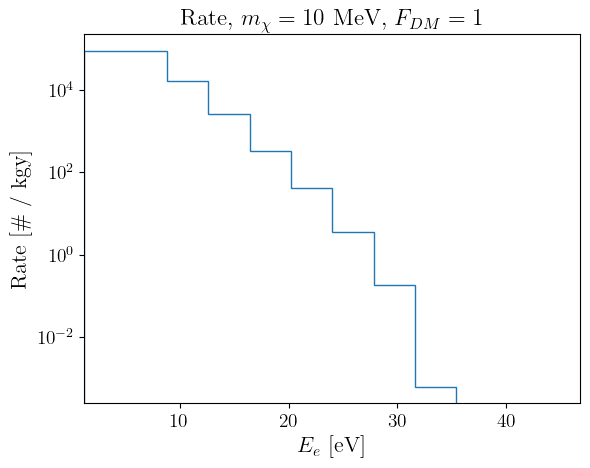

In [8]:

fig1 = plt.figure()
E_vals = Si_Crystal.get_evals()
plt.hist(E_vals[:-1], E_vals, weights=My_Rates, lw=1., histtype='step')
plt.yscale('log')
plt.xlim((E_vals[0], E_vals[-1]))
plt.xlabel(r'$E_e$ [eV]')
plt.ylabel('Rate [\# / kgy]')
plt.title(r'Rate, $m_{\chi}=10$ MeV, $F_{DM}=1$')
plt.show()


/tmp/ipykernel_18791/3013621640.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(mX2*1e-6, My_Xsec)


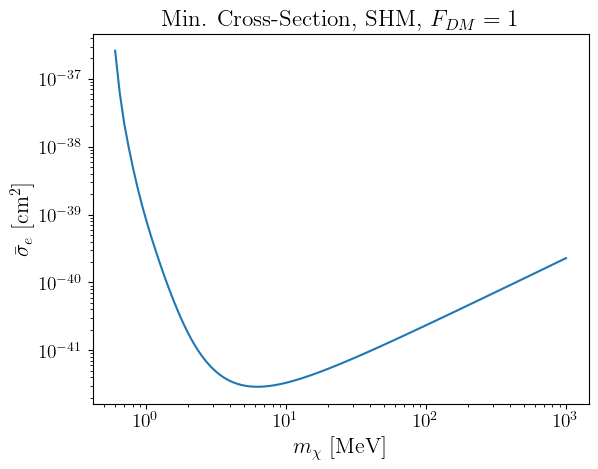

In [9]:

fig2 = plt.figure()
plt.plot(mX2*1e-6, My_Xsec)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$m_{\chi}$ [MeV]')
plt.ylabel(r'$\bar{\sigma}_e$ [cm$^2$]')
plt.title(r'Min. Cross-Section, SHM, $F_{DM}=1$')
plt.show()